In [0]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, sum, window, desc

# Create a SparkSession
spark = SparkSession.builder.appName("Online Retail Cleaning").getOrCreate()
df1 = spark.read.csv("/FileStore/tables/online_retail_2009_2010_-2.csv", header=True, inferSchema=True)
df2 = spark.read.csv("/FileStore/tables/online_retail_2010_2011_-2.csv", header=True, inferSchema=True)

# Combine datasets using union
combined_df = df1.unionByName(df2)

# Drop rows with null values in key columns
cleaned_df = combined_df.dropna(subset=["Invoice", "StockCode", "InvoiceDate", "Customer ID", "Quantity"])

# Remove duplicate rows
cleaned_df = cleaned_df.dropDuplicates()

In [0]:
from pyspark.sql.functions import col, round

# Add a TotalPrice column rounded to 2 decimal places
transformed_df = cleaned_df.withColumn("TotalPrice", round(col("Quantity") * col("Price"), 2))
print("Transformed Dataset with TotalPrice:")
transformed_df.show(5)

Transformed Dataset with TotalPrice:
+-------+---------+--------------------+--------+----------------+-----+-----------+--------------+----------+
|Invoice|StockCode|         Description|Quantity|     InvoiceDate|Price|Customer ID|       Country|TotalPrice|
+-------+---------+--------------------+--------+----------------+-----+-----------+--------------+----------+
| 489437|    21912|VINTAGE SNAKES & ...|       4|01-12-2009 09:08| 3.75|      15362|United Kingdom|      15.0|
| 489438|    21100|CHARLIE AND LOLA ...|      30|01-12-2009 09:24| 1.15|      18102|United Kingdom|      34.5|
| 489514|    21955|UNION JACK GUNS &...|      10|01-12-2009 11:21| 5.95|      15311|United Kingdom|      59.5|
| 489522|    22294|HEART FILIGREE DO...|       6|01-12-2009 11:45| 1.25|      15998|United Kingdom|       7.5|
| 489526|    22232|JIGSAW TOADSTOOLS...|       8|01-12-2009 11:50| 1.65|      12533|       Germany|      13.2|
+-------+---------+--------------------+--------+----------------+-----+---

In [0]:
# Group data by Country and calculate total sales, rounded to 2 decimal places
country_sales_df = transformed_df.groupBy("Country") \
    .sum("TotalPrice") \
    .withColumnRenamed("sum(TotalPrice)", "TotalSales") \
    .withColumn("TotalSales", round(col("TotalSales"), 2))  # Round to 2 decimal places
print("Total Sales Per Country:")
country_sales_df.show()

Total Sales Per Country:
+------------------+----------+
|           Country|TotalSales|
+------------------+----------+
|            Sweden|  87421.52|
|         Singapore|  13158.16|
|           Germany| 411959.16|
|               RSA|   1933.74|
|            France| 320046.26|
|            Greece|  18995.49|
|European Community|   1291.75|
|           Belgium|  63208.89|
|           Finland|  29514.45|
|             Malta|   5192.22|
|       Unspecified|   7370.46|
|           Nigeria|    140.39|
|             Italy|   30254.1|
|              EIRE| 573509.76|
|         Lithuania|   4892.68|
|            Norway|  35455.91|
|             Spain|  91013.44|
|           Denmark|  64459.59|
|       West Indies|    536.41|
|          Thailand|   3070.54|
+------------------+----------+
only showing top 20 rows



In [0]:
# Group data by StockCode and Description, calculate total sales, rounded to 2 decimal places
top_products_df = transformed_df.groupBy("StockCode", "Description") \
    .sum("TotalPrice") \
    .withColumnRenamed("sum(TotalPrice)", "TotalSales") \
    .withColumn("TotalSales", round(col("TotalSales"), 2)) \
    .orderBy(col("TotalSales").desc()) \
    .limit(10)
print("Top 10 Best-Selling Products:")
top_products_df.show()

Top 10 Best-Selling Products:
+---------+--------------------+----------+
|StockCode|         Description|TotalSales|
+---------+--------------------+----------+
|    22423|REGENCY CAKESTAND...| 261110.95|
|   85123A|WHITE HANGING HEA...| 237678.61|
|   85099B|JUMBO BAG RED RET...| 132180.02|
|    84879|ASSORTED COLOUR B...| 123631.87|
|     POST|             POSTAGE| 110338.51|
|    47566|       PARTY BUNTING| 102089.38|
|    22086|PAPER CHAIN KIT 5...|  75388.48|
|    79321|       CHILLI LIGHTS|   68453.5|
|   85099F|JUMBO BAG STRAWBERRY|  63615.53|
|    21137|BLACK RECORD COVE...|  63009.83|
+---------+--------------------+----------+



In [0]:
# Group data by Customer ID and calculate total sales
top_customers_df = transformed_df \
    .groupBy("Customer ID") \
    .sum("TotalPrice") \
    .withColumnRenamed("sum(TotalPrice)", "TotalSales") \
    .withColumn("TotalSales", round(col("TotalSales"), 2)) \
    .orderBy(col("TotalSales").desc()) \
    .limit(10)

# Display top customers by sales
print("Top 10 Customers by Sales:")
top_customers_df.show(truncate=False)

Top 10 Customers by Sales:
+-----------+----------+
|Customer ID|TotalSales|
+-----------+----------+
|18102      |570380.61 |
|14646      |523342.07 |
|14156      |296063.44 |
|14911      |265757.91 |
|17450      |231390.55 |
|13694      |190020.84 |
|17511      |168491.62 |
|12415      |143269.29 |
|16684      |141502.25 |
|15061      |124961.98 |
+-----------+----------+



In [0]:
# Grouping sales by product category (Description) and calculating total sales
sales_by_category_df = transformed_df \
    .groupBy("Description") \
    .sum("TotalPrice") \
    .withColumnRenamed("sum(TotalPrice)", "TotalSales") \
    .withColumn("TotalSales", round(col("TotalSales"), 2)) \
    .orderBy(col("TotalSales").desc())

# Display the top categories based on sales
print("Sales by Product Category (Top 10):")
sales_by_category_df.show(truncate=False)

Sales by Product Category (Top 10):
+-----------------------------------+----------+
|Description                        |TotalSales|
+-----------------------------------+----------+
|REGENCY CAKESTAND 3 TIER           |261110.95 |
|WHITE HANGING HEART T-LIGHT HOLDER |237678.61 |
|JUMBO BAG RED RETROSPOT            |132180.02 |
|ASSORTED COLOUR BIRD ORNAMENT      |123631.87 |
|POSTAGE                            |110338.51 |
|PARTY BUNTING                      |102089.38 |
|PAPER CHAIN KIT 50'S CHRISTMAS     |75388.48  |
|CHILLI LIGHTS                      |68453.5   |
|JUMBO BAG STRAWBERRY               |63615.53  |
|BLACK RECORD COVER FRAME           |63009.83  |
|ROTATING SILVER ANGELS T-LIGHT HLDR|55577.77  |
|WOOD BLACK BOARD ANT WHITE FINISH  |54200.36  |
|VINTAGE UNION JACK BUNTING         |53888.62  |
|EDWARDIAN PARASOL NATURAL          |53563.46  |
|JUMBO  BAG BAROQUE BLACK WHITE     |51617.3   |
|RABBIT NIGHT LIGHT                 |51042.84  |
|HEART OF WICKER LARGE           

In [0]:
# Group by Country and calculate total sales
country_sales_df = transformed_df \
    .groupBy("Country") \
    .sum("TotalPrice") \
    .withColumnRenamed("sum(TotalPrice)", "TotalSales") \
    .withColumn("TotalSales", round(col("TotalSales"), 2)) \
    .orderBy(col("TotalSales").desc()) \
    .limit(5)

# Display top 5 countries
print("Top 5 Countries by Sales:")
country_sales_df.show(truncate=False)

Top 5 Countries by Sales:
+--------------+-------------+
|Country       |TotalSales   |
+--------------+-------------+
|United Kingdom|1.348250507E7|
|EIRE          |573509.76    |
|Netherlands   |548330.7     |
|Germany       |411959.16    |
|France        |320046.26    |
+--------------+-------------+



In [0]:
from pyspark.sql.functions import when

# Define segmentation based on total sales
customer_segmentation_df = transformed_df \
    .groupBy("Customer ID") \
    .sum("TotalPrice") \
    .withColumnRenamed("sum(TotalPrice)", "TotalSales") \
    .withColumn("SalesSegment", when(col("TotalSales") < 50, "Low")
                .when((col("TotalSales") >= 50) & (col("TotalSales") < 200), "Medium")
                .otherwise("High"))

# Display customer segmentation
print("Customer Segmentation by Sales:")
customer_segmentation_df.show(truncate=False)

Customer Segmentation by Sales:
+-----------+------------------+------------+
|Customer ID|TotalSales        |SalesSegment|
+-----------+------------------+------------+
|15727      |9371.710000000003 |High        |
|16574      |1301.7799999999997|High        |
|17679      |3166.56           |High        |
|18051      |2275.9799999999996|High        |
|13623      |2412.9300000000003|High        |
|13285      |3364.59           |High        |
|13289      |307.95            |High        |
|17389      |54577.68          |High        |
|15447      |484.93            |High        |
|12799      |219.35000000000002|High        |
|16503      |3597.8900000000003|High        |
|16861      |924.48            |High        |
|14450      |1128.44           |High        |
|14570      |613.7499999999999 |High        |
|13832      |598.64            |High        |
|15957      |921.2500000000001 |High        |
|13840      |651.4             |High        |
|17753      |379.56000000000006|High        |
|1

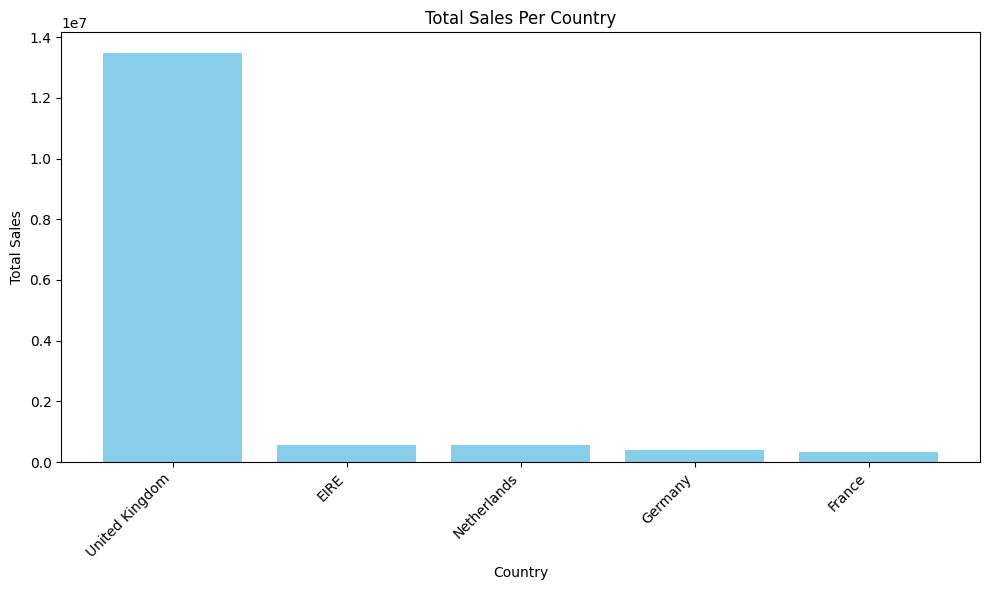

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas for visualization
country_sales_pd = country_sales_df.toPandas()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(country_sales_pd['Country'], country_sales_pd['TotalSales'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Total Sales")
plt.title("Total Sales Per Country")
plt.tight_layout()
plt.show()

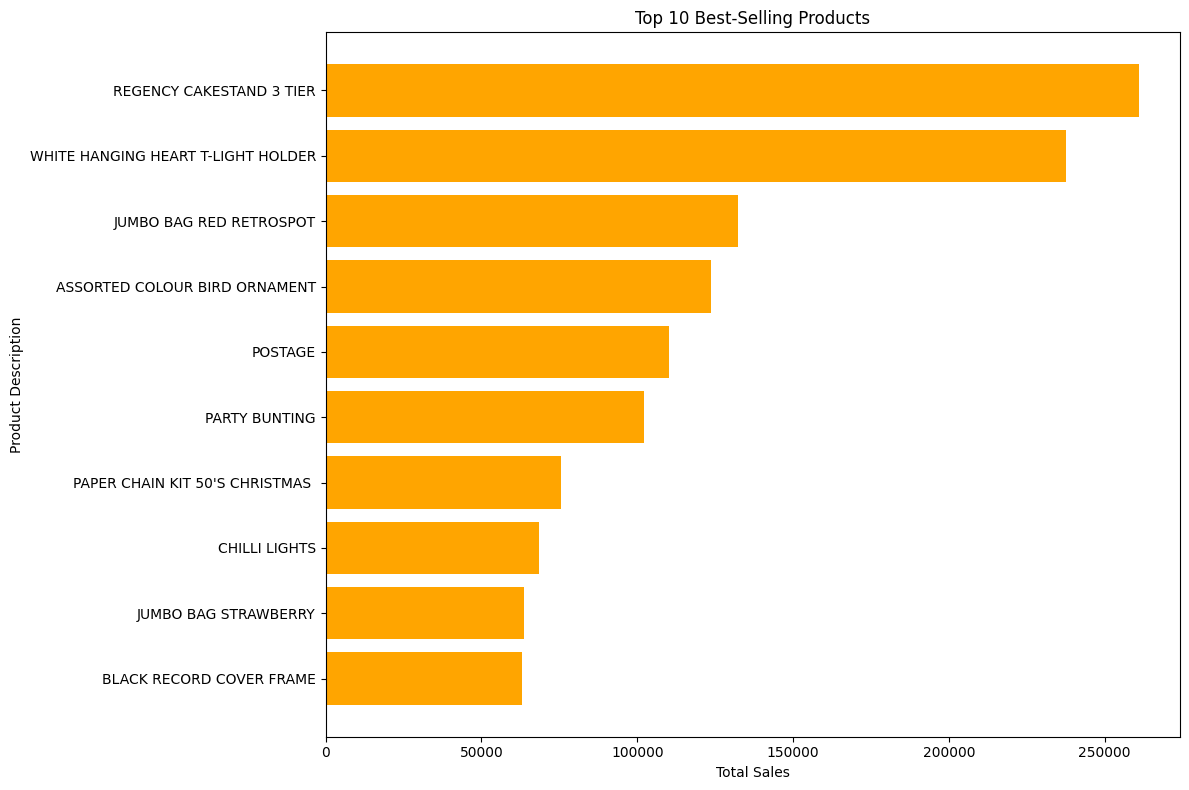

In [0]:
# Convert to Pandas
top_products_pd = top_products_df.toPandas()

# Plot horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_products_pd['Description'], top_products_pd['TotalSales'], color='orange')
plt.xlabel("Total Sales")
plt.ylabel("Product Description")
plt.title("Top 10 Best-Selling Products")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

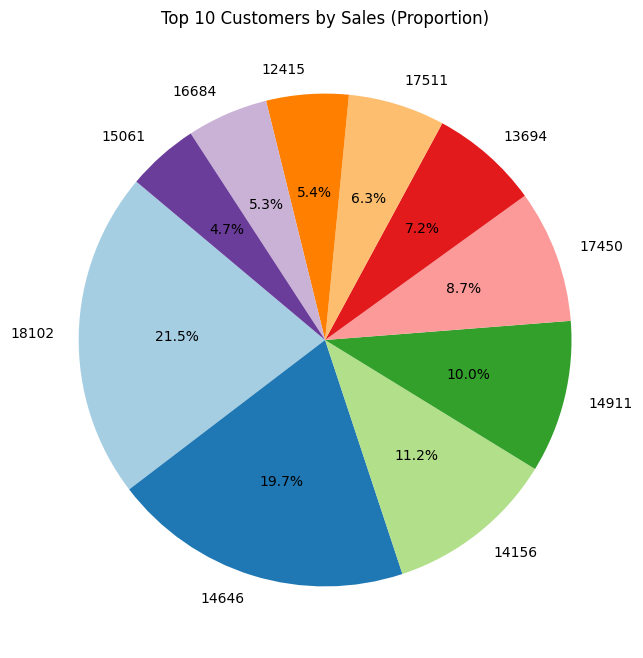

In [0]:
# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_customers_pd['TotalSales'], labels=top_customers_pd['Customer ID'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Top 10 Customers by Sales (Proportion)")
plt.show()

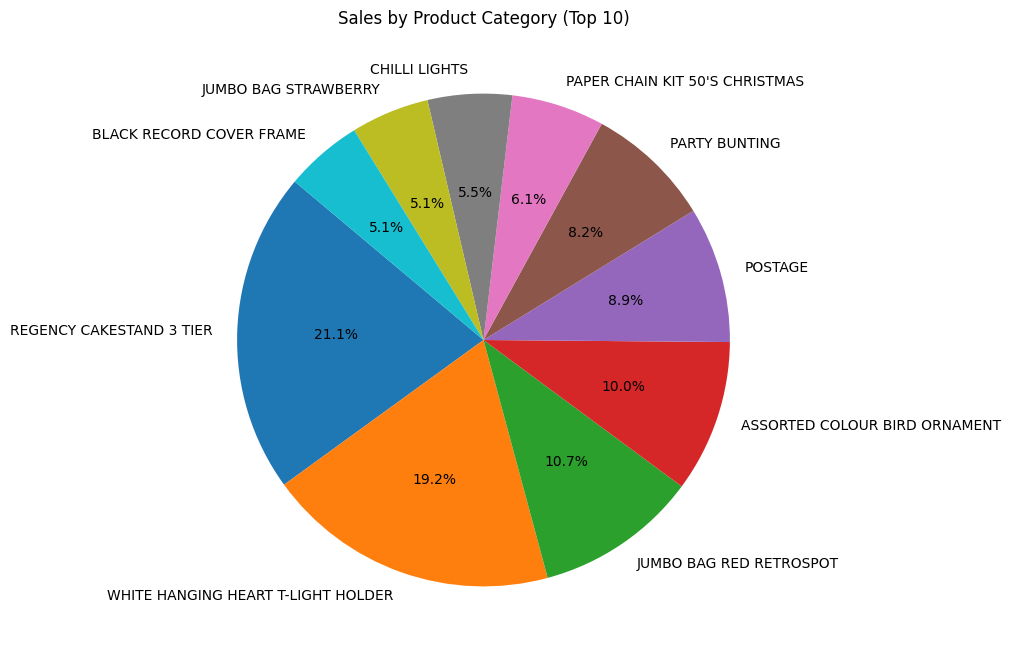

In [0]:
# Convert to Pandas
sales_by_category_pd = sales_by_category_df.limit(10).toPandas()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(sales_by_category_pd['TotalSales'], labels=sales_by_category_pd['Description'], autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title("Sales by Product Category (Top 10)")
plt.show()

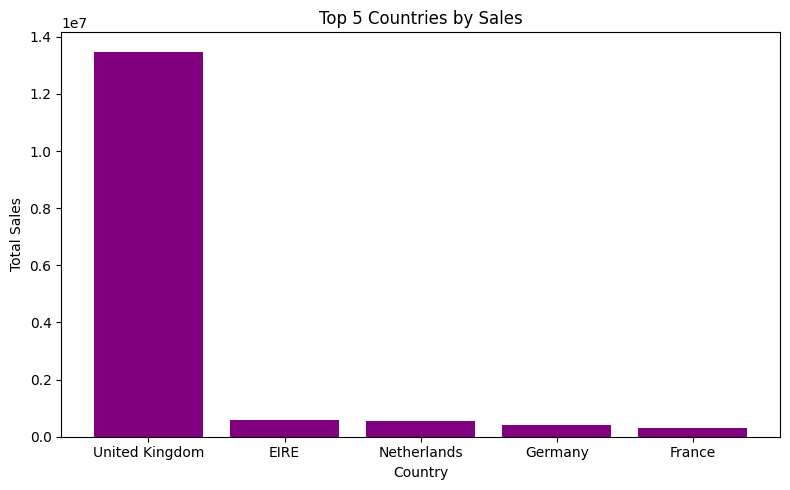

In [0]:
# Convert to Pandas
top_countries_pd = country_sales_df.toPandas()

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(top_countries_pd['Country'], top_countries_pd['TotalSales'], color='purple')
plt.xlabel("Country")
plt.ylabel("Total Sales")
plt.title("Top 5 Countries by Sales")
plt.tight_layout()
plt.show()

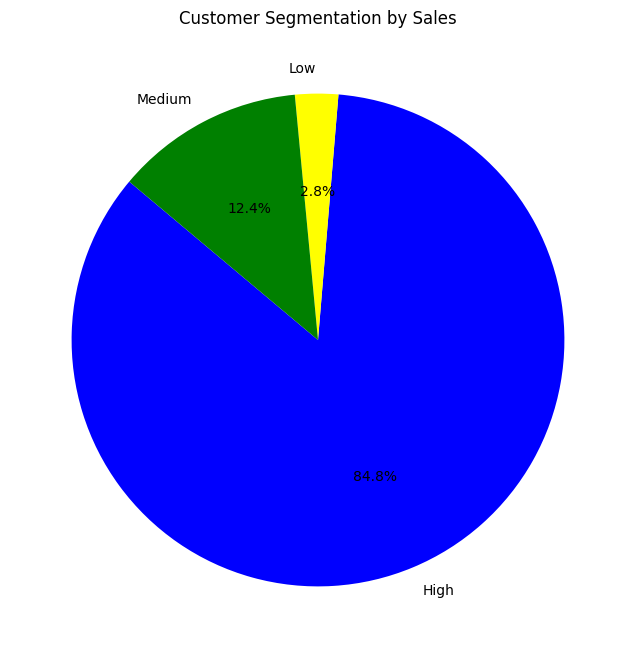

In [0]:
# Convert to Pandas
customer_segmentation_pd = customer_segmentation_df.groupBy("SalesSegment").count().toPandas()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(customer_segmentation_pd['count'], labels=customer_segmentation_pd['SalesSegment'], autopct='%1.1f%%', startangle=140, colors=['blue', 'yellow', 'green'])
plt.title("Customer Segmentation by Sales")
plt.show()

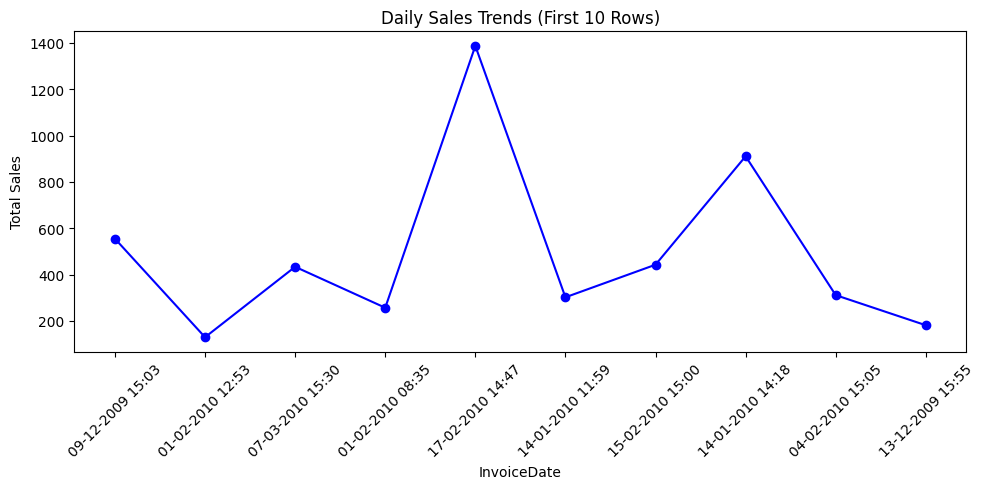

In [0]:
# Example: Visualize total sales by day (First 10 rows for quick plotting)
daily_sales_pd = transformed_df.groupBy("InvoiceDate").sum("TotalPrice").limit(10).toPandas()

# Plot line chart
plt.figure(figsize=(10, 5))
plt.plot(daily_sales_pd['InvoiceDate'], daily_sales_pd['sum(TotalPrice)'], marker='o', color='blue')
plt.xlabel("InvoiceDate")
plt.ylabel("Total Sales")
plt.title("Daily Sales Trends (First 10 Rows)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()